In [1]:
#Data analysis and math
import math
from math import sqrt
import datetime
import numpy as np
import pandas as pd
from scipy import stats as st
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

#Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats import mstats

# models
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#Metrics
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer

# gridsearch
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

/Users/saranshgupta/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/saranshgupta/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


** Call Functions **

In [2]:
def prepare_for_ML(df, test_period = 500):
    "Prepare the dataset for testing"
    df = df.copy()
    training_df = df[:-test_period]
    testing_df = df[len(df)-test_period:]
    X_train = training_df.drop(["price"],axis=1)
    y_train = training_df["price"]
    X_test = testing_df.drop(["price"],axis=1)
    y_test = testing_df["price"]

    df_pred = df.drop(['price'], axis=1)    
    
    return df_pred, X_train, X_test, y_train, y_test

def print_eval(model, x, y):
    """Prints some evaluation metrics"""

    y_pred = model.predict(x)
    print('{:15} {:.5f}'.format('R^2 coefficient:', model.score(x, y)))
    print('{:15} {:.5f}'.format('Rmse:', np.sqrt(mean_squared_error(y,y_pred))))
    print('{:15} {:.5f}'.format('MAE:', (mean_absolute_error(y,y_pred))))

** Read in Data **

In [166]:
electricity = pd.read_csv('electricity.csv')
price = pd.read_csv('TS1.csv')
temperature = pd.read_csv('temperature.csv')

pd.set_option("display.max_columns", 100)

In [3]:
data = pd.read_excel('data.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'data.xlsx'

In [167]:
#Examine columns, missing values, and data types
price.info()

electricity.info()

temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 2 columns):
date     8750 non-null object
price    8750 non-null float64
dtypes: float64(1), object(1)
memory usage: 136.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24632 entries, 0 to 24631
Data columns (total 5 columns):
date                         24632 non-null object
value                        24632 non-null int64
generation                   24608 non-null float64
difference                   24632 non-null int64
day_ahead_demand_forecast    24632 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 962.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
datetime             45253 non-null object
Vancouver            44458 non-null float64
Portland             45252 non-null float64
San Francisco        44460 non-null float64
Seattle              45250 non-null float64
Los Angeles          45250

Potential processing tasks: 

    1) Different number of rows.
    2) NaN in generation column in electricity dataset
    3) The price data is taken from homes in the Bay Area, so we are only interested in the San Francisco temperature

** Data Cleaning**

Filter the temperature dataset and fix the column labels

In [168]:
temperature = temperature[['datetime','San Francisco']]
temperature.columns = ['date','temperature']
electricity.columns = ['date','demand', 'generation', 'ANI','day_ahead_demand_forecast']

Convert date column in datasets to datetime and sort in ascending order

In [169]:
temperature['date'] = pd.to_datetime(temperature['date'])
price['date'] = pd.to_datetime(price['date'])
electricity['date'] = pd.to_datetime(electricity['date'])

temperature = temperature.sort_values(['date'])
price = price.sort_values(['date'])
electricity = electricity.sort_values(['date'])


Round datetime values down to nearest hour in order to merge datasets on a common index

In [170]:
temperature['date'] = temperature['date'].map(lambda x: x.replace(minute=0, second=0, microsecond=0))
price['date'] = price['date'].map(lambda x: x.replace(minute=0, second=0, microsecond=0))
electricity['date'] = electricity['date'].map(lambda x: x.replace(minute=0, second=0, microsecond=0))


Set date as index and restrict data sets for dates in the calendar year 2016. Merge filtered 2016 datasets to single dataset

In [171]:
temperature.set_index('date',inplace=True)
price.set_index('date',inplace=True)
electricity.set_index('date',inplace=True)

In [172]:
temperature_16 = temperature.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']
price_16 = price.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']
electricity_16 = electricity.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']

In [173]:
df = temperature_16.merge(price_16, how='outer', left_index=True, right_index=True)
df = df.merge(electricity_16, how='outer', left_index=True, right_index=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 7 columns):
date                         8750 non-null datetime64[ns]
temperature                  8750 non-null float64
price                        8750 non-null float64
demand                       8750 non-null int64
generation                   8750 non-null float64
ANI                          8750 non-null int64
day_ahead_demand_forecast    8750 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 478.6 KB


** Feature Engineering **

Create categorical variable for Month

In [175]:
df['month'] = df['date'].map(lambda x: x.month).astype('category')
df_month = pd.get_dummies(df['month'], drop_first=False)
df_month.columns = ['Jan','Feb','Mar','Apr', 'May', 'June', 'July', 'Aug','Sep', 'Oct','Nov','Dec']

Create categorical variable for Hour

In [176]:
df['hour'] = df['date'].map(lambda x: x.hour).astype('category')
df_hour = pd.get_dummies(df['hour'],drop_first=False)

Append Month and Hour variables to dataset

In [177]:
df = pd.concat([df, df_hour], axis=1)
df = pd.concat([df, df_month], axis=1)

df.set_index(keys="date", inplace=True)

Create categorical variable for day of week

In [178]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).weekday == i).astype(int)

In [179]:
df['day_of_week'] = df[names].idxmax(axis=1)

Create categorical variable to indicate weekday vs weekend

In [180]:
weekend = ['Saturday','Sunday']

df['is_weekend'] = df['day_of_week'].isin(weekend)*1

Lets take a look at the features in the dataset. We can observe that there are 8,750 observations and there are no missing values

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8750 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 53 columns):
temperature                  8750 non-null float64
price                        8750 non-null float64
demand                       8750 non-null int64
generation                   8750 non-null float64
ANI                          8750 non-null int64
day_ahead_demand_forecast    8750 non-null int64
month                        8750 non-null category
hour                         8750 non-null category
0                            8750 non-null uint8
1                            8750 non-null uint8
2                            8750 non-null uint8
3                            8750 non-null uint8
4                            8750 non-null uint8
5                            8750 non-null uint8
6                            8750 non-null uint8
7                            8750 non-null uint8
8                            8750 non-null uint8
9           

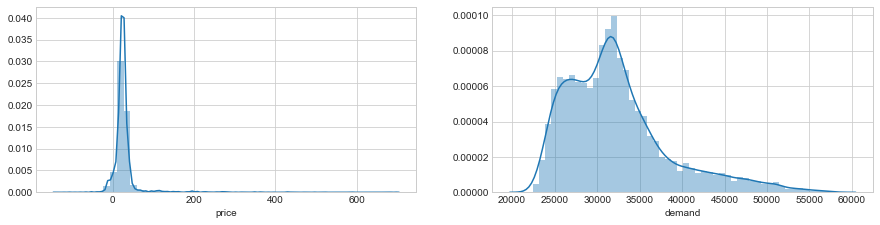

In [182]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.distplot(df['price'])

ax2 = fig.add_subplot(222)
sns.distplot(df['demand'])

In [183]:
df[['price']].describe()

,price
count,8750.000000
mean,28.360163
std,40.668379
min,-141.936123
25%,17.578296
50%,23.860545
75%,29.874502
max,699.391742


In [184]:
maxPrice = df['price'].mean() + 2*df['price'].std()
minPrice = df['price'].mean() - 2*df['price'].std()
print("Number of observations two std's above the mean:", len(df['price'][df['price'] >= maxPrice].value_counts()))
print("% of total:", len(df['price'][df['price'] >= maxPrice].value_counts())/len(df))

print("Number of observations two std's below the mean:", len(df['price'][df['price'] <= minPrice].value_counts()))
print("% of total:", len(df['price'][df['price'] <= minPrice].value_counts())/len(df))

Number of observations two std's above the mean: 231
% of total: 0.0264
Number of observations two std's below the mean: 6
% of total: 0.0006857142857142857


In [185]:
df['price'] = mstats.winsorize(df['price'], limits=[0.05, 0.05])

Forecasting price should now feel less impacted by the outliers

In [186]:
df[['price']].describe()

,price
count,8750.000000
mean,23.668046
std,11.796162
min,-1.670591
25%,17.578296
50%,23.860545
75%,29.874502
max,49.391338


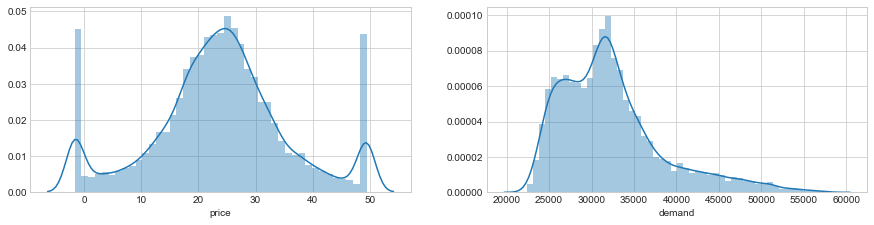

In [187]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.distplot(df['price'])

ax2 = fig.add_subplot(222)
sns.distplot(df['demand'])

The chart below shows a correlation between the base features

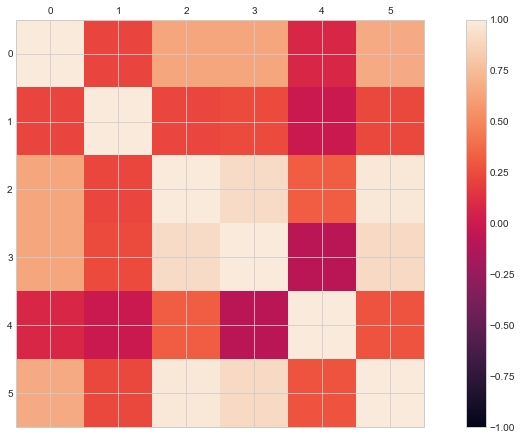

,temperature,price,demand,generation,ANI,day_ahead_demand_forecast
temperature,1.000000,0.220177,0.643017,0.643631,0.080621,0.669156
price,0.220177,1.000000,0.231786,0.244735,-0.001034,0.242102
demand,0.643017,0.231786,1.000000,0.916532,0.324998,0.981590
generation,0.643631,0.244735,0.916532,1.000000,-0.080377,0.913652
ANI,0.080621,-0.001034,0.324998,-0.080377,1.000000,0.285928
day_ahead_demand_forecast,0.669156,0.242102,0.981590,0.913652,0.285928,1.000000


In [188]:
data = df[['temperature', 'price', 'demand', 'generation', 'ANI', 'day_ahead_demand_forecast']]
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

plt.show()
correlations

**Observations**:
    * There isn't a strong relationship between price and the other features. We will need to create features from the datetime index in order to capture the potential trend and seasonality components.
    * The day-ahead demand forecast is highly correlated with the current day forecast. This implies demand can be predicted using a random walk model. We assume that price will follow a similar trajectory. An ARIMA model will be able to model this relationship.
    * We can drop day_ahead_demand_forecast due to its high correlation with demand

In [189]:
df.drop('day_ahead_demand_forecast', axis=1, inplace=True)

** Data Exploration **

**Observations**:
    * The price of energy was very low in February, March, and April and begins to ascend from the Summer until November / December.
    * The demand for energy is highest in the summer months.
    * The price of energy by hour has two peaks - the morning and the evening. It is lowest during traditional working hours. This is our strongest indicator of what predicts energy prices. We can use this to form a baseline prediction model.

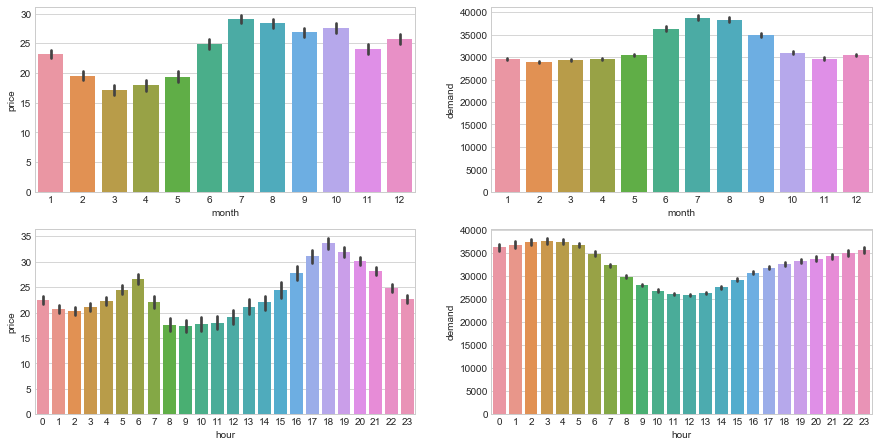

In [190]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="month", y="price", data=df)

ax2 = fig.add_subplot(222)
sns.barplot(x="month", y="demand", data=df)

ax3 = fig.add_subplot(223)
sns.barplot(x="hour", y="price", data=df)

ax4 = fig.add_subplot(224)
sns.barplot(x="hour", y="demand", data=df)


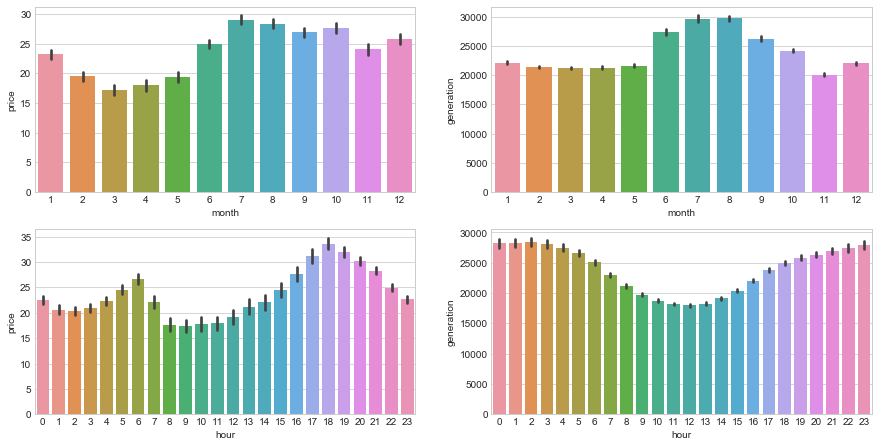

In [191]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="month", y="price", data=df)

ax2 = fig.add_subplot(222)
sns.barplot(x="month", y="generation", data=df)

ax3 = fig.add_subplot(223)
sns.barplot(x="hour", y="price", data=df)

ax4 = fig.add_subplot(224)
sns.barplot(x="hour", y="generation", data=df)

Clearly there is a strong relationship between demand and generation, but we don't appear to learn anything new about energy prices.

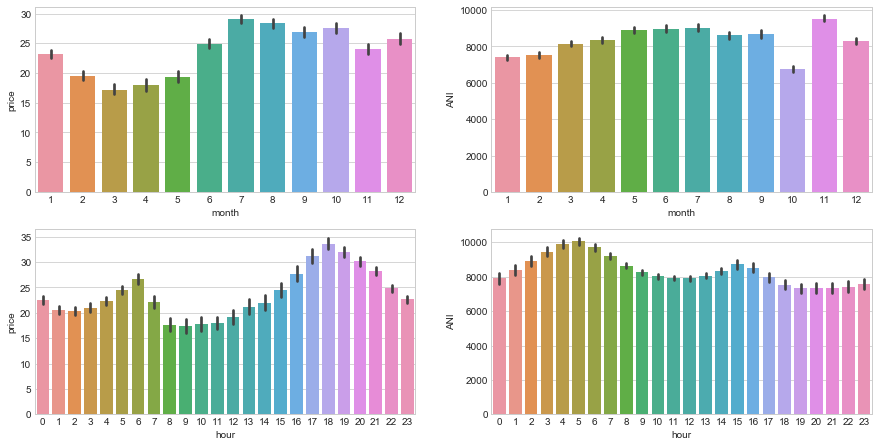

In [192]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="month", y="price", data=df)

ax2 = fig.add_subplot(222)
sns.barplot(x="month", y="ANI", data=df)

ax3 = fig.add_subplot(223)
sns.barplot(x="hour", y="price", data=df)

ax4 = fig.add_subplot(224)
sns.barplot(x="hour", y="ANI", data=df)

There isn't a clear trend here between ANI and prices. Lets explore this further from a binary perspective. We will create a binary variable to indicate whether the Actual Net Interchange (ANI) is negative. As shown in the figure below, there is a clear relationship between this and price.

Note: A positive value of ANI means that there is a net import of power into the Control Area. A negative value of ANI means that there is a net export of power out of the Control Area

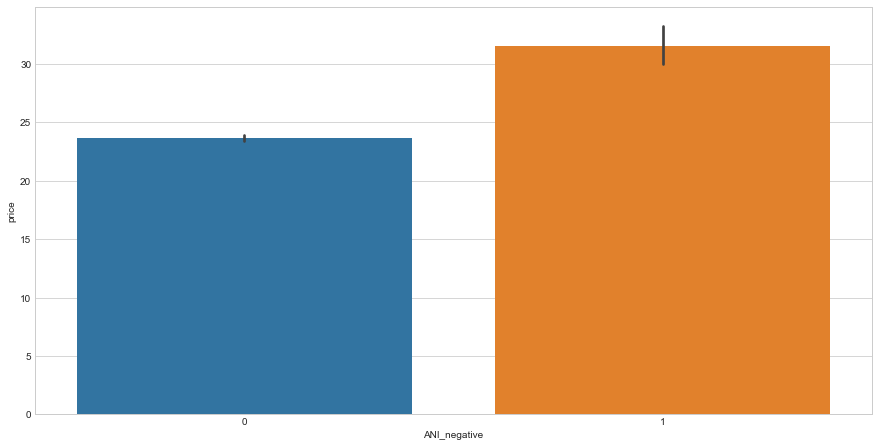

In [193]:
df['ANI_negative'] = np.where(df['ANI'] < 0, 1, 0)
sns.barplot(x="ANI_negative", y="price", data=df)

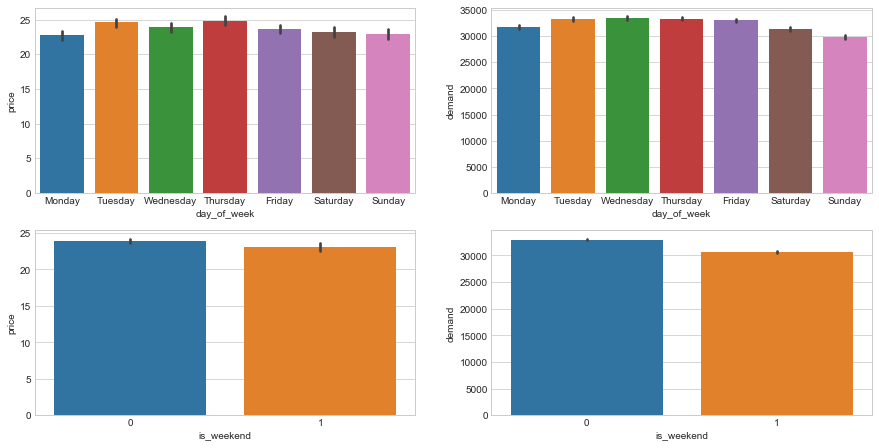

In [194]:
fig = plt.figure()

df['day_of_week'] = pd.Categorical(df['day_of_week'], 
                                   categories=['Monday','Tuesday','Wednesday',
                                               'Thursday','Friday','Saturday', 'Sunday'], ordered=True)
df_by_day = df[['is_weekend','day_of_week', 'price', 'demand']].sort_index()

ax1 = fig.add_subplot(221)
sns.barplot(x="day_of_week", y="price", data=df)

ax2 = fig.add_subplot(222)
sns.barplot(x="day_of_week", y="demand", data=df_by_day)

ax3 = fig.add_subplot(223)
sns.barplot(x="is_weekend", y="price", data=df)

ax4 = fig.add_subplot(224)
sns.barplot(x="is_weekend", y="demand", data=df_by_day)

We observe above that while there is a discernible difference in electricity demand on the weekend, there is no clear difference in the price of energy.

In [195]:
df.drop('is_weekend', axis=1, inplace=True)

In [196]:
x = df["demand"]
y = df["price"]

r, p = st.pearsonr(x, y)

print("The correlation between consumption and price is {}, with a p-value of {}".format(r, p))

The correlation between consumption and price is 0.23178602362664372, with a p-value of 4.6286815197799587e-107


In [197]:
x = df["generation"]
y = df["price"]

r, p = st.pearsonr(x, y)

print("The correlation between generation and price is {}, with a p-value of {}".format(r, p))

The correlation between generation and price is 0.2447351903955785, with a p-value of 1.6378630046447591e-119


In [198]:
x = df["ANI"]
y = df["price"]

r, p = st.pearsonr(x, y)

print("The correlation between ANI and price is {}, with a p-value of {}".format(r, p))

The correlation between ANI and price is -0.0010339689134343784, with a p-value of 0.9229605550415454


Lets drop ANI since its value is mostly capture with "ANI_negative"

In [199]:
df.drop('ANI', axis =1, inplace=True)

In [200]:
by_month = df[['price','demand','generation','month']].groupby('month').mean()
by_month

,price,demand,generation
month,,,
1,23.161192,29555.397574,22157.176550
2,19.528754,28892.768012,21378.795389
3,17.171362,29425.109459,21271.717568
4,17.935846,29635.525070,21261.541783
5,19.397959,30474.328378,21573.958108
6,24.879404,36317.783217,27330.504895
7,29.026589,38719.605121,29677.460916
8,28.374065,38329.551957,29712.862348
9,26.874508,34932.372385,26233.331939


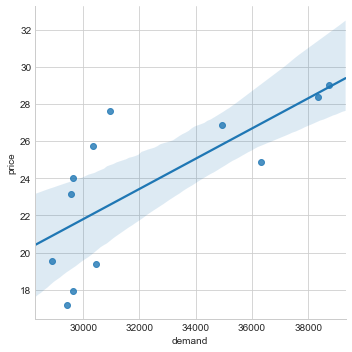

In [201]:
sns.lmplot(x='demand', y='price', data=by_month)

In [202]:
by_day_of_week = df[['price','demand','generation','day_of_week']].groupby('day_of_week').mean()
by_day_of_week

,price,demand,generation
day_of_week,,,
Monday,22.734663,31783.768489,21878.411576
Tuesday,24.577736,33250.380338,23476.934730
Wednesday,23.882495,33421.271774,24835.522581
Thursday,24.774824,33344.647059,24919.943594
Friday,23.604425,32995.086682,24744.720252
Saturday,23.184016,31344.922109,24519.308419
Sunday,22.935503,29849.221865,23081.959003


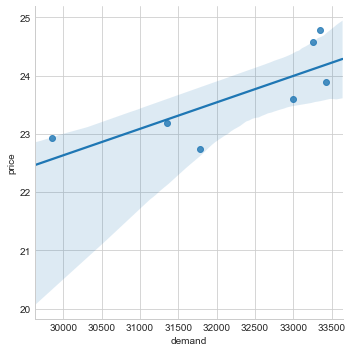

In [203]:
sns.lmplot(x='demand', y='price', data=by_day_of_week)

For our baseline prediction, we would predict the price for each hour to be the mean of each hour of the subsequent year. We will use this to compare our test results.

In [204]:
by_hour = df[['price','demand','generation','hour']].groupby('hour').mean()
by_hour

,price,demand,generation
hour,,,
0,22.504611,36165.052486,28248.116022
1,20.634518,36679.775342,28280.542466
2,20.323463,37335.876374,28406.925824
3,21.026857,37572.131148,28107.931694
4,22.331101,37409.830601,27510.642077
5,24.540859,36645.978142,26587.158470
6,26.582648,34786.153425,25062.035616
7,22.079348,32225.904110,23001.643836
8,17.643694,29780.208219,21126.827397


In [205]:
baseline_prediction = df[['hour','price']].groupby('hour').transform('mean')

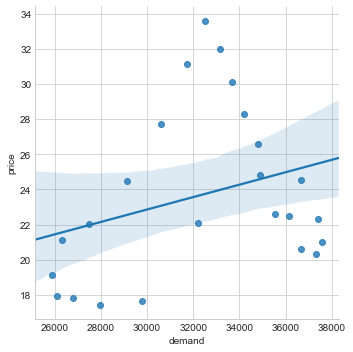

In [206]:
sns.lmplot(x='demand', y='price', data=by_hour)

** More feature engineering **

One potential feature we could create is a categorical feature that assigns a value to a month based on how far it deviates from the mean. For this feature we tried to bin the months into three groups based on by_month price means.

In [207]:
month_defaults = df.groupby("month")["price"].mean()

low_price = sorted(month_defaults)[3]
mid_price = sorted(month_defaults)[6]
high_price = sorted(month_defaults)[9]

new_month = {}

for month in month_defaults.index:
    if low_price > month_defaults[month]:
        v = "MonthLowPrice"
    elif mid_price > month_defaults[month] >= low_price:
        v = "MonthMidLowPrice"
    elif high_price > month_defaults[month] >= mid_price:
        v = "MonthMidHighPrice"
    else:
        v = "MonthHighPrice"

    new_month[month] = v

df.replace(to_replace={"month": new_month}, inplace=True)
                               
df[['price','month']].groupby('month').mean().sort_values('price')

,price
month,
MonthLowPrice,18.170717
MonthMidLowPrice,22.277738
MonthMidHighPrice,25.829352
MonthHighPrice,28.334943


In [208]:
df = pd.concat([df, pd.get_dummies(df['month'], drop_first=False)], axis=1)

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8750 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 55 columns):
temperature          8750 non-null float64
price                8750 non-null float64
demand               8750 non-null int64
generation           8750 non-null float64
month                8750 non-null object
hour                 8750 non-null category
0                    8750 non-null uint8
1                    8750 non-null uint8
2                    8750 non-null uint8
3                    8750 non-null uint8
4                    8750 non-null uint8
5                    8750 non-null uint8
6                    8750 non-null uint8
7                    8750 non-null uint8
8                    8750 non-null uint8
9                    8750 non-null uint8
10                   8750 non-null uint8
11                   8750 non-null uint8
12                   8750 non-null uint8
13                   8750 non-null uint8
14                   8750 n

## Seasonal ARIMA model

We want to create a baseline model to model the relationship between time and the price of energy. To do this we model price using a time-series ARIMA modeling method. The purpose is to see whether the price in the previous hour is able to successfully predict the price in the subsequent hour. Further, we understand that there is a 24-hour seasonal component in the data.

We will fit the data to an ARIMA model and create an ARIMA prediction feature, which will be used when we train our machine learning models later on.

** Hyper Tuning **

To determine the ideal ARIMA parameters we used a libary called Pyramid developed by T.G. Smith that's based on R's auto-arima package. The model essentially replicates GridSearch to find the optimal parameters based on AIC. 

For memory purposes, we used only three months worth of data. However, given the consistency in the data, we feel this is sufficient for hyper-tuning purposes

Source: https://github.com/tgsmith61591/pyramid

In [210]:
#!pip install pyramid-arima

In [211]:
#timeseries = df.loc['2016-11-01 00:00:00':'2016-12-15 23:00:00']
#timeseries = timeseries['price'].values
#len(timeseries)

In [212]:
#from pyramid.arima import auto_arima

#stepwise_fit = auto_arima(timeseries, start_p=1, start_q=1, max_p=3, max_q=3, m=24,
#                          start_P=0, seasonal=True, d=1, D=1, trace=True,
#                          error_action='ignore',  # don't want to know if an order does not work
#                        suppress_warnings=True,  # don't want convergence warnings
#                      stepwise=True)  # set to stepwise

#print(stepwise_fit.summary())

* Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=7297.226, BIC=7322.131, Fit time=9.683 seconds
* Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
* Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 24); AIC=7673.230, BIC=7693.155, Fit time=3.027 seconds
* Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 24); AIC=7400.339, BIC=7420.263, Fit time=4.260 seconds
* Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 24); AIC=7288.220, BIC=7318.106, Fit time=11.599 seconds
* Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 24); AIC=7543.128, BIC=7568.033, Fit time=12.780 seconds
* Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 24); AIC=7285.829, BIC=7320.696, Fit time=42.946 seconds
* Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 24); AIC=7400.823, BIC=7430.709, Fit time=40.261 seconds
* Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 24); AIC=nan, BIC=nan, Fit time=nan seconds
* Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 24); AIC=7413.320, BIC=7443.206, Fit time=36.771 seconds
* Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 24); AIC=7288.724, BIC=7328.573, Fit time=47.198 seconds
* Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 24); AIC=7439.800, BIC=7464.705, Fit time=37.993 seconds
* Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 2, 24); AIC=7289.667, BIC=7334.496, Fit time=57.371 seconds
* Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 24); AIC=7282.253, BIC=7312.139, Fit time=27.401 seconds
* Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 24); AIC=7398.992, BIC=7423.897, Fit time=12.693 seconds
* Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 24); AIC=nan, BIC=nan, Fit time=nan seconds
* Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 2, 24); AIC=7411.533, BIC=7436.438, Fit time=14.150 seconds
* Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 2, 24); AIC=7284.298, BIC=7319.165, Fit time=43.597 seconds
* Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 24); AIC=7437.406, BIC=7457.330, Fit time=11.241 seconds
* Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 2, 24); AIC=7285.793, BIC=7325.641, Fit time=54.040 seconds
* Total fit time: 467.026 seconds

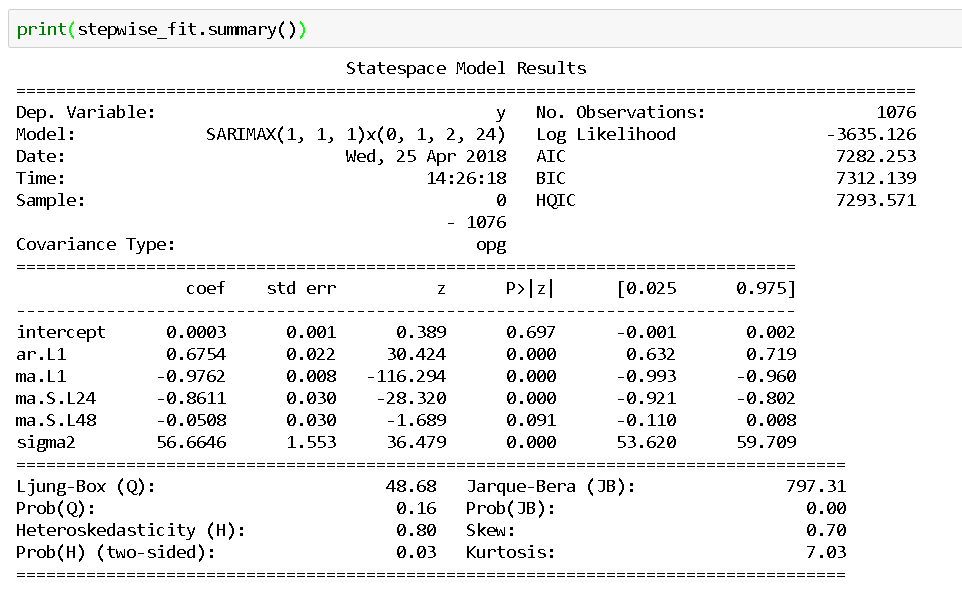

We fit the ARIMA model with the parameters (1,1,1), (0,1,2) with a 24 hour seasonality component.

In [213]:
# Best SARIMAX model
timeseries = df['price'].values
ARIMA = SARIMAX(timeseries,order=(1,1,1), 
                seasonal_order=(0,1,2,24), enforce_invertibility=False)   
model_fit = ARIMA.fit()

In [214]:
df['ARIMA'] = model_fit.fittedvalues

As shown below, the ARIMA model does a good job capturing the general trend in the data, but struggles at times to capture the highest price values. We will model the additional features in the dataset to hopefully identify nuances in the dataset that may capture these values better.

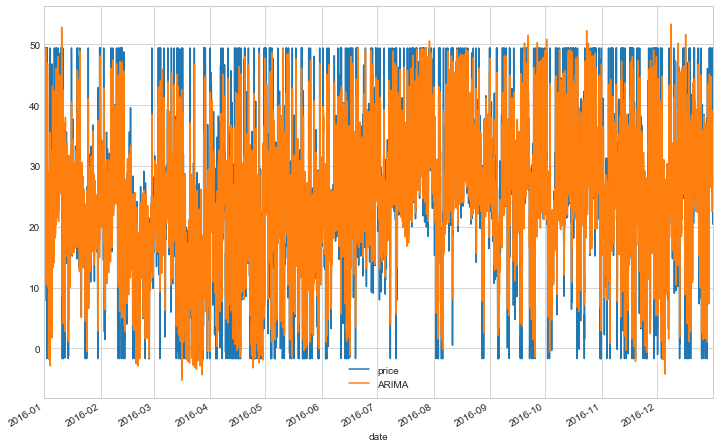

In [215]:
df[['price','ARIMA']].plot(figsize=(12,8))

** Machine Learning to refine predictions **

We first need to drop some redundant variables (day_of_week, hour). We will save the column order for the forecast dataset.

In [216]:
df.corr()['price']

temperature          0.220177
price                1.000000
demand               0.231786
generation           0.244735
0                   -0.020490
1                   -0.053657
2                   -0.059074
3                   -0.046784
4                   -0.023682
5                    0.015460
6                    0.051554
7                   -0.028101
8                   -0.106559
9                   -0.110601
10                  -0.103488
11                  -0.101646
12                  -0.079727
13                  -0.044319
14                  -0.028662
15                   0.013875
16                   0.071433
17                   0.132183
18                   0.175900
19                   0.146949
20                   0.114545
21                   0.081379
22                   0.020531
23                  -0.018482
Jan                 -0.013080
Feb                 -0.102998
Mar                 -0.167408
Apr                 -0.145297
May                 -0.110032
June      

In [217]:
df.drop(['day_of_week','hour','month'], axis=1, inplace=True)
#df.drop(['Jan','Feb','Mar','Apr', 'May', 'June', 'July', 'Aug','Sep', 'Oct','Nov','Dec'], axis=1, inplace=True)
df.drop(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1, inplace=True) #Low correlation w/ price
df.drop(['MonthLowPrice', 'MonthMidLowPrice', 'MonthMidHighPrice', 'MonthHighPrice'], axis=1, inplace=True) # Strongly correlated w/Months and prefer months for modeling purposes
df.drop(['ANI_negative'], axis=1, inplace=True) # Poor correlation

In [218]:
#Save column order for final prediction
colm_order = df.columns
colm_order

Index(['temperature',       'price',      'demand',  'generation',
                   0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,            13,            14,            15,
                  16,            17,            18,            19,
                  20,            21,            22,            23,
               'Jan',         'Feb',         'Mar',         'Apr',
               'May',        'June',        'July',         'Aug',
               'Sep',         'Oct',         'Nov',         'Dec',
             'ARIMA'],
      dtype='object')

The function below splits the dataset into a training set and a testing set. The testing set in this case is the last 30 percent of the dataset. Assigning training and testing sequentially instead of random sampling is common practice in time-series analysis. In addition, this function also prepares the dataset for prediction for the final model later on.

In [219]:
test_size = int(0.3 * df.shape[0])
pred, X_train, X_test, y_train, y_test = prepare_for_ML(df, test_period=test_size)

In [220]:
print("Xtrain:",X_train.shape)
print("ytrain:",y_train.shape)
print("Xtest:",X_test.shape)
print("ytest:",y_test.shape)
print("pred:",pred.shape)

Xtrain: (6125, 40)
ytrain: (6125,)
Xtest: (2625, 40)
ytest: (2625,)
pred: (8750, 40)


**Feature Scaling **

We also want to try different feature scaling approaches to see whether performance can be improved. 

In [221]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
pred_scaled = scaler.transform(pred)

In [222]:
pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_pca10 = pca.transform(X_train_scaled)
X_test_pca10 = pca.transform(X_test_scaled)
pred_pca10 = pca.transform(pred_scaled)

pca.explained_variance_ratio_

array([ 0.0860936 ,  0.06302434,  0.06167515,  0.0616346 ,  0.06039756,
        0.0599621 ,  0.05841799,  0.0337845 ,  0.0256014 ,  0.02424374])

In [223]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)

X_train_pca3 = pca.transform(X_train_scaled)
X_test_pca3 = pca.transform(X_test_scaled)
pred_pca3 = pca.transform(pred_scaled)

pca.explained_variance_ratio_

array([ 0.08609399,  0.06302657,  0.06167654])

** Model Fitting **

In [224]:
print("Xtrain:",X_train.shape)
print("ytrain:",y_train.shape)
print("Xtest:",X_test.shape)
print("ytest:",y_test.shape)
print("Xtrain_scaled:",X_train_scaled.shape)
print("Xtrain_pca10:",X_train_pca10.shape)
print("Xtrain_pca3:",X_train_pca3.shape)

print("pred:",pred.shape)

Xtrain: (6125, 40)
ytrain: (6125,)
Xtest: (2625, 40)
ytest: (2625,)
Xtrain_scaled: (6125, 40)
Xtrain_pca10: (6125, 10)
Xtrain_pca3: (6125, 3)
pred: (8750, 40)


The cell below automates the process of fitting various models to the different types of scaled features.

In [225]:
import warnings

models = {"Linear Regression": LinearRegression(), "RidgeCV": RidgeCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), cv=10),
          "Random Forest": RandomForestRegressor(), "Decision Tree": DecisionTreeRegressor(),
          "Lasso": LassoCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), cv=10),
         "MLP": MLPRegressor()}

data = {"": X_train, "(scaled data)": X_train_scaled,
        "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3}
data2 = {"": X_test, "(scaled data)": X_test_scaled,
      "(PCA: 10 components)": X_test_pca10, "(PCA: 3 components)": X_test_pca3}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in models.items():
        for (scale, X_trn), (scale,X_tst) in zip(data.items(), data2.items()):
            n = name + " " + scale
            s0, m0 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            model.fit(X_trn, y_train)
            s1, m1 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            regr = model
            trainscore = regr.score(X_trn, y_train)
            testscore = regr.score(X_tst, y_test)           
            trainy_pred = regr.predict(X_trn)
            testy_pred = regr.predict(X_tst)
            trainrmse = np.sqrt(mean_squared_error(y_train,trainy_pred))
            testrmse = np.sqrt(mean_squared_error(y_test,testy_pred))
            trainmae = mean_absolute_error(y_train,trainy_pred)
            testmae = mean_absolute_error(y_test,testy_pred)
            m_delta = m1 - m0
            s_delta = s1 - s0
            if s_delta < 0:
                s_delta = 60 + s_delta
                m_delta -= 1

            res[n] = {"Train_Score": trainscore, "Train_RMSE": trainrmse, "Train_MAE": trainmae,
                      "Test_Score": testscore, "Test_RMSE": testrmse, "Test_MAE": testmae,
                      "TrainingTime (m)": m_delta, "TrainingTime (s)": s_delta}


results = pd.DataFrame.from_dict(res, orient="index")
results = results[["Train_Score", "Train_RMSE", "Train_MAE",
                   "Test_Score", "Test_RMSE", "Test_MAE",
                   "TrainingTime (m)", "TrainingTime (s)"]]

results

,Train_Score,Train_RMSE,Train_MAE,Test_Score,Test_RMSE,Test_MAE,TrainingTime (m),TrainingTime (s)
Decision Tree,1.000000,6.570801e-06,1.800147e-07,1.795727e-01,1.055058e+01,7.494364e+00,0,0
Decision Tree (PCA: 10 components),1.000000,6.121583e-06,1.957143e-07,1.008671e-02,1.158924e+01,8.765382e+00,0,0
Decision Tree (PCA: 3 components),1.000000,7.852385e-17,1.065814e-17,1.632279e-01,1.065516e+01,7.652830e+00,0,0
Decision Tree (scaled data),1.000000,6.570801e-06,1.800147e-07,1.748649e-01,1.058081e+01,7.464175e+00,0,0
Lasso,0.658178,6.835953e+00,4.553678e+00,6.429045e-01,6.960630e+00,4.684536e+00,0,0
Lasso (PCA: 10 components),0.341469,9.488270e+00,6.982614e+00,1.572582e-01,1.069310e+01,8.152465e+00,0,0
Lasso (PCA: 3 components),0.200175,1.045674e+01,7.684209e+00,6.338029e-03,1.161116e+01,8.809679e+00,0,0
Lasso (scaled data),0.658011,6.837624e+00,4.562167e+00,6.417555e-01,6.971819e+00,4.701695e+00,0,0
Linear Regression,0.658616,6.831565e+00,4.561211e+00,-5.522492e+12,2.737309e+07,2.506509e+07,0,0
Linear Regression (PCA: 10 components),0.347885,9.441930e+00,6.982368e+00,1.839062e-01,1.052268e+01,7.994629e+00,0,0


The Lasso CV model (unscaled) gave the best results. We will run a grid search to see if we can improve performance.

In [226]:
results["Test_RMSE"].argmin(), results["Test_RMSE"].min()

('Lasso ', 6.9606302999170468)

In [93]:
default_RMSE = make_scorer(score_func=mean_squared_error)

param_grid = {"n_estimators": np.arange(2, 10, 2),
              "max_depth": np.arange(1, 10, 1),
              "min_samples_split": np.arange(2,10,1),
              "min_samples_leaf": np.arange(1,6,1),
              "max_leaf_nodes": np.arange(2,6,1),
              "min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)}

forest = RandomForestRegressor()
#regr = GridSearchCV(forest, param_grid=param_grid, cv=5, scoring=default_RMSE,verbose=1, n_jobs=-1)

#regr.fit(X_train_pca3, y_train)

#regr.best_params_, regr.best_score_ 

In [95]:
default_RMSE = make_scorer(score_func=mean_squared_error)

param_grid = {"n_alphas": np.arange(50, 200, 25),
              "selection": ['cyclic','random']}

lasso = LassoCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), max_iter=10000, cv=10)
regr = GridSearchCV(lasso, param_grid=param_grid, cv=10, scoring=default_RMSE,verbose=1, n_jobs=-1)

regr.fit(X_train, y_train)

regr.best_params_, np.sqrt(regr.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.3s finished


({'n_alphas': 50, 'selection': 'random'}, 6.8857199730971779)

In [ ]:
default_RMSE = make_scorer(score_func=mean_squared_error)


param_grid = {"normalize": ['True', 'False'],
              "fit_intercept": ['True', 'False'],
              "gcv_mode": ['auto','svd','eigen']}

ridge = RidgeCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), cv=10, scoring='neg_mean_squared_error')
regr = GridSearchCV(ridge, param_grid=param_grid, cv=10, scoring=default_RMSE,verbose=1, n_jobs=-1)

regr.fit(X_train, y_train)

regr.best_params_, np.sqrt(regr.best_score_)

In [ ]:
default_RMSE = make_scorer(score_func=mean_squared_error)


param_grid = {'alpha': [10,1,.01,10e-2,10e-3,], 
              'hidden_layer_sizes': [(10, ), (10,10), (5, ), (5, 5)],
              'tol': [1e-2, 1e-3, 1e-4], 
              'epsilon': [1e-3, 1e-7, 1e-8]}

mlp = MLPRegressor()
regr = GridSearchCV(mlp, param_grid=param_grid, cv=10, scoring=default_RMSE,verbose=1, n_jobs=-1)

regr.fit(X_train_scaled, y_train)

regr.best_params_, np.sqrt(regr.best_score_)

In [227]:
#regr = RandomForestRegressor(max_depth=6, max_leaf_nodes=5, min_samples_leaf=5, 
#                             min_samples_split=8, min_weight_fraction_leaf=0.4, n_estimators=2)
#regr = RidgeCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), fit_intercept=True, gcv_mode='auto', normalize=True, cv=10, scoring='neg_mean_squared_error')

regr = LassoCV(alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3), n_alphas=50, selection='random', cv=10)

regr.fit(X_train, y_train)

LassoCV(alphas=(0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0), copy_X=True, cv=10,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=50, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='random', tol=0.0001, verbose=False)

**Deep Learning with Keras**

We wanted to build a deep learning model to see if the model's predictive power could be further enhanced. We will compare the results from this model to the ARIMA and Lasso model, as well as a stacked model which is a simple average of the three models to see what outputs the best results

In [228]:
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [229]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13183022225842562693
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9410969
locality {
  bus_id: 1
}
incarnation: 11585087789579186188
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [230]:
X = df.drop(['price'], axis=1)
Y = df['price']

scaler = MinMaxScaler()
scaler.fit(X)

Xscaled = scaler.transform(X)

In [231]:
train_size = int(0.7 * X.shape[0])
Xtrain, Xtest, ytrain, ytest = Xscaled[0:train_size], Xscaled[train_size:], Y[0:train_size], Y[train_size:]

In [234]:
size = len(df.columns)
predictions = Input(shape=(size-1,))
x = Dense(16, activation="relu", kernel_initializer="glorot_uniform")(predictions)
price = Dense(1, kernel_initializer="glorot_uniform")(x)
model = Model(inputs=[predictions], outputs=[price])
model.compile(loss="mse", optimizer="adam")

In [235]:
NUM_EPOCHS = 50
BATCH_SIZE = 2
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Train on 4900 samples, validate on 1225 samples
Epoch 1/50
4900/4900 [==============================] - 9s 2ms/step - loss: 171.3948 - val_loss: 127.5303
Epoch 2/50
4900/4900 [==============================] - 9s 2ms/step - loss: 75.6021 - val_loss: 91.5992
Epoch 3/50
4900/4900 [==============================] - 9s 2ms/step - loss: 62.3548 - val_loss: 75.3942
Epoch 4/50
4900/4900 [==============================] - 9s 2ms/step - loss: 55.4472 - val_loss: 63.9356
Epoch 5/50
4900/4900 [==============================] - 9s 2ms/step - loss: 52.1973 - val_loss: 59.9053
Epoch 6/50
4900/4900 [==============================] - 9s 2ms/step - loss: 50.7852 - val_loss: 46.6133
Epoch 7/50
4900/4900 [==============================] - 9s 2ms/step - loss: 50.1331 - val_loss: 52.7122
Epoch 8/50
4900/4900 [==============================] - 10s 2ms/step - loss: 49.7725 - val_loss: 47.7984
Epoch 9/50
4900/4900 [==============================] - 9s 2ms/step - loss: 49.5058 - val_loss: 42.4215
Epoch 10/50
4

In [236]:
ytest_ = model.predict(Xtest).flatten()
for i in range(10):
    label = ytest[i]
    prediction = ytest_[i]
    print("Price expected: {:.3f}, predicted: {:.3f}".format(label, prediction))


Price expected: 31.625, predicted: 31.663
Price expected: 32.415, predicted: 27.373
Price expected: 33.559, predicted: 23.316
Price expected: 27.134, predicted: 22.133
Price expected: 27.461, predicted: 25.166
Price expected: 24.223, predicted: 28.888
Price expected: 20.204, predicted: 24.771
Price expected: 18.061, predicted: 26.649
Price expected: 7.768, predicted: 27.416
Price expected: 7.123, predicted: 15.101


Create keras model prediction

In [237]:
prediction_ = model.predict(Xscaled).flatten()
results = df.copy()
results['keras'] = prediction_

Create Lasso model prediction

In [238]:
pred = regr.predict(pred)
results['price_pred'] = pred

Create baseline model prediction (by hour average prediction)

In [239]:
results['baseline'] = baseline_prediction

In [240]:
results[['keras','ARIMA','baseline','price_pred']].describe()

,keras,ARIMA,baseline,price_pred
count,8750.000000,8750.000000,8750.000000,8750.000000
mean,22.492552,23.665900,23.668046,23.591774
std,8.911694,10.300598,4.659191,9.468082
min,-6.272854,-5.214649,17.424061,-2.834387
25%,17.620712,17.528163,20.323463,17.835316
50%,23.174430,23.890890,22.504611,23.675782
75%,28.186810,29.678959,27.706536,29.126692
max,46.083282,53.323572,33.598440,51.869175


The stack prediction is a simple average of the Keras, Lasso, and Arima models

In [241]:
results['stack'] = (results['keras'] + results['ARIMA'] + results['price_pred']) / 3

As shown below, the stacked model performs the best. All trained models outperform the baseline model on both the training and testing periods. While the difference isn't substantial, it may indicate some improvements in predictive power.

In [243]:
train = results[:-test_size]
test = results[len(df) -test_size:]

train_baseline_rmse = np.sqrt(mean_squared_error(train['price'], train['baseline']))
print('Baseline Train RMSE: %.3f' % train_baseline_rmse)
train_arima_rmse = np.sqrt(mean_squared_error(train['price'], train['ARIMA']))
print('Arima Train RMSE: %.3f' % train_arima_rmse)
train_keras_rmse = np.sqrt(mean_squared_error(train['price'], train['keras']))
print('Keras Train RMSE: %.3f' % train_keras_rmse)
train_ML_rmse = np.sqrt(mean_squared_error(train['price'], train['price_pred']))
print('ML Train RMSE: %.3f' % train_ML_rmse)
train_stack_rmse = np.sqrt(mean_squared_error(train['price'], train['stack']))
print('Stacked Train RMSE: %.3f' % train_stack_rmse)


print("")

test_baseline_rmse = np.sqrt(mean_squared_error(test['price'], test['baseline']))
print('Baseline Test RMSE: %.3f' % test_baseline_rmse)
test_arima_rmse = np.sqrt(mean_squared_error(test['price'], test['ARIMA']))
print('Arima Test RMSE: %.3f' % test_arima_rmse)
test_ML_rmse = np.sqrt(mean_squared_error(test['price'], test['keras']))
print('Keras Test RMSE: %.3f' % test_ML_rmse)
test_ML_rmse = np.sqrt(mean_squared_error(test['price'], test['price_pred']))
print('ML Test RMSE: %.3f' % test_ML_rmse)
test_stack_rmse = np.sqrt(mean_squared_error(test['price'], test['stack']))
print('Stacked Test RMSE: %.3f' % test_stack_rmse)

Baseline Train RMSE: 10.902
Arima Train RMSE: 6.985
Keras Train RMSE: 6.752
ML Train RMSE: 6.836
Stacked Train RMSE: 6.748

Baseline Test RMSE: 10.682
Arima Test RMSE: 7.036
Keras Test RMSE: 7.493
ML Test RMSE: 6.961
Stacked Test RMSE: 6.952


**Training Period Plot**

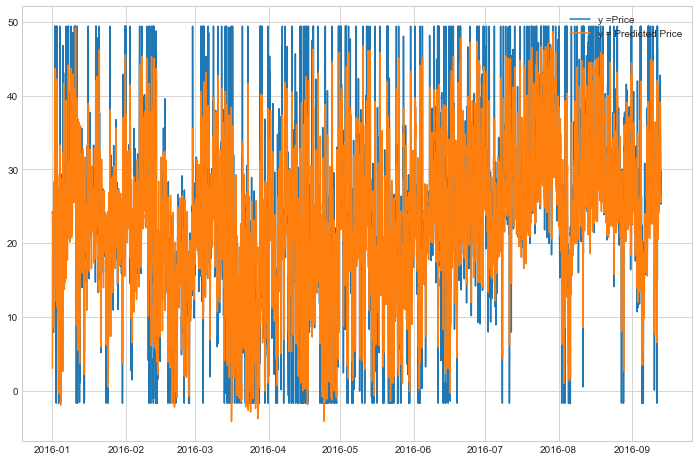

In [244]:
plt.plot(train['price'])
plt.plot(train['stack'])

plt.legend(['y =Price', 'y = Predicted Price'], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12,8)

plt.show()


**Test period prediction plot **

Overall , the model does a good job capturing general trends, which is important for forecasting purposes.

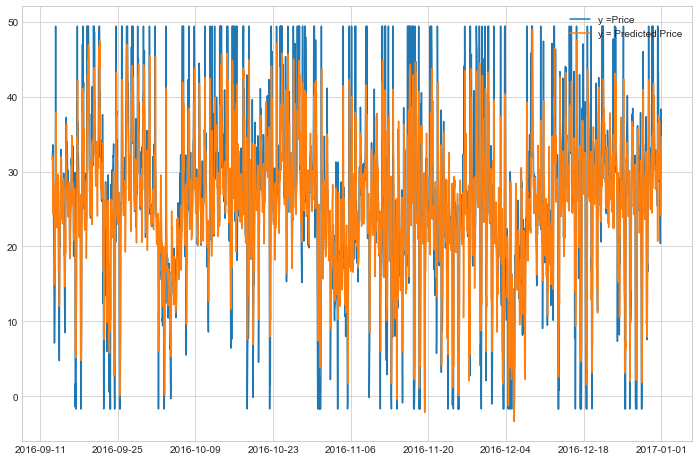

In [245]:
plt.plot(test['price'])
plt.plot(test['stack'])

plt.legend(['y =Price', 'y = Predicted Price'], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12,8)

plt.show()

** Predict next 24 hours **

We need to prepare the features that correspond to the next 24 hours for 01/01/2017. 

In [246]:
forecast_period = 24
future_df = df[['price']].copy()
future_dates = [df.index[-1] + DateOffset(hours=x) for x in range(0,forecast_period+1) ]
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=future_df.columns)

In [247]:
future_dates_df = future_dates_df.merge(electricity.loc['2017-01-01 00:00:00':'2017-01-01 23:00:00'], how='outer', left_index=True, right_index=True)
future_dates_df = future_dates_df.merge(temperature.loc['2017-01-01 00:00:00':'2017-01-01 23:00:00'], how='outer', left_index=True, right_index=True)
future_dates_df.head()

,price,demand,generation,ANI,day_ahead_demand_forecast,temperature
2017-01-01 00:00:00,NaN,29392,20641.0,8751,27653,284.47
2017-01-01 01:00:00,NaN,30872,21421.0,9451,29405,282.61
2017-01-01 02:00:00,NaN,33760,23728.0,10032,33022,281.89
2017-01-01 03:00:00,NaN,33976,24048.0,9928,33492,280.54
2017-01-01 04:00:00,NaN,33053,23336.0,9717,33095,280.24


In [248]:
future_dates_df.reset_index(inplace=True)
future_dates_df['index'] = pd.to_datetime(future_dates_df['index'])
future_dates_df['hour'] = future_dates_df['index'].map(lambda x: x.hour).astype('category')
future_dates_df['month'] = future_dates_df['index'].map(lambda x: x.month).astype('category')

df_hour = pd.get_dummies(future_dates_df['hour'], drop_first=False)

df_month = electricity.reset_index()
df_month.drop(['demand','generation','ANI','day_ahead_demand_forecast'], axis=1, inplace=True)
df_month['month'] = df_month['date'].map(lambda x: x.month).astype('category')
df_month['index'] = df_month['date']
df_month.set_index(keys="index", inplace=True)
months = pd.get_dummies(df_month['month'], drop_first=False)
months.columns = ['Jan','Feb','Mar','Apr', 'May', 'June', 'July', 'Aug','Sep', 'Oct','Nov','Dec']
df_month = pd.concat([df_month, months], axis=1)
df_month.replace(to_replace={"month": new_month}, inplace=True)
df_month = pd.concat([df_month, pd.get_dummies(df_month['month'], drop_first=False)], axis=1)
df_month = df_month.loc['2017-01-01 00:00:00':'2017-01-01 23:00:00']
df_month.reset_index(inplace=True)
df_month.drop('index', axis=1, inplace=True)

future_dates_df = pd.concat([future_dates_df, df_hour], axis=1)
future_dates_df = pd.concat([future_dates_df, df_month], axis=1)

future_dates_df.set_index(keys="index", inplace=True)

names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, x in enumerate(names):
    future_dates_df[x] = (future_dates_df.index.get_level_values(0).weekday == i).astype(int)

future_dates_df['day_of_week'] = future_dates_df[names].idxmax(axis=1)

weekend = ['Saturday','Sunday']
future_dates_df['is_weekend'] = future_dates_df['day_of_week'].isin(weekend)*1
future_dates_df.drop('date', axis=1, inplace=True)
future_dates_df['ANI_negative'] = np.where(future_dates_df['ANI'] < 0, 1, 0)

In [249]:
len(future_dates_df)

24

For the ARIMA column values we will use the forecasting feature to predict the next 24 hours.

In [250]:
future_dates_df['ARIMA'] = model_fit.forecast(24,)

We will align the 1/1/17 dataset features with the 2016 dataset features that were used for training the models

In [251]:
next_24 = future_dates_df[colm_order]

In [252]:
print(next_24.columns)
print(colm_order)

Index(['temperature',       'price',      'demand',  'generation',
                   0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,            13,            14,            15,
                  16,            17,            18,            19,
                  20,            21,            22,            23,
               'Jan',         'Feb',         'Mar',         'Apr',
               'May',        'June',        'July',         'Aug',
               'Sep',         'Oct',         'Nov',         'Dec',
             'ARIMA'],
      dtype='object')
Index(['temperature',       'price',      'demand',  'generation',
                   0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                 

In [253]:
next_24.drop('price',axis=1, inplace=True)
next_24.head()

C:\Users\Jorda\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,temperature,demand,generation,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Jan,Feb,Mar,Apr,May,June,July,Aug,Sep,Oct,Nov,Dec,ARIMA
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,284.47,29392,20641.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,33.969327
2017-01-01 01:00:00,282.61,30872,21421.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,31.859225
2017-01-01 02:00:00,281.89,33760,23728.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,30.842131
2017-01-01 03:00:00,280.54,33976,24048.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,32.618396
2017-01-01 04:00:00,280.24,33053,23336.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,33.645127


** Final Model + Prediction **

For the final prediction we want to train on the entire dataset based off the selected parameters from the training process. We also need to scale the dataset similar to the training process

In [254]:
def prepare_for_prediction(df):
    "Prepare the dataset for testing"
    training_df = df.copy()
    X_full = training_df.drop(["price"],axis=1)
    y_full = training_df["price"] 
    
    return X_full, y_full

X_full, y_full = prepare_for_prediction(df)

In [255]:
scaler = MinMaxScaler()
scaler.fit(X_full)

X_full_scaled = scaler.transform(X_full)
next_24_scaled = scaler.transform(next_24)

Train the Keras deep learning model

In [256]:
history = model.fit(X_full_scaled, y_full, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.2)

Train on 7000 samples, validate on 1750 samples
Epoch 1/50
7000/7000 [==============================] - 12s 2ms/step - loss: 44.1052 - val_loss: 53.9458
Epoch 2/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.6582 - val_loss: 53.4917
Epoch 3/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.5666 - val_loss: 53.3634
Epoch 4/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.4246 - val_loss: 55.0194
Epoch 5/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.4346 - val_loss: 54.1805
Epoch 6/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.3685 - val_loss: 53.6277
Epoch 7/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.2902 - val_loss: 54.8057
Epoch 8/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.3397 - val_loss: 52.9876
Epoch 9/50
7000/7000 [==============================] - 12s 2ms/step - loss: 43.2965 - val_loss: 54.7379
Epoch 1

In [257]:
forecast = next_24.copy()
prediction_ = model.predict(next_24_scaled).flatten()
forecast['keras'] = prediction_

Train a final Lasso model on the full dataset

In [258]:
regr = regr.fit(X_full, y_full)
pred_24 = regr.predict(next_24)
forecast['price_pred'] = pred_24

Average the Keras, Lasso, Arima models for a final stacked prediction

In [259]:
forecast[['keras','ARIMA','price_pred']]
forecast['stack'] = (forecast['keras'] + forecast['ARIMA'] + forecast['price_pred']) / 3

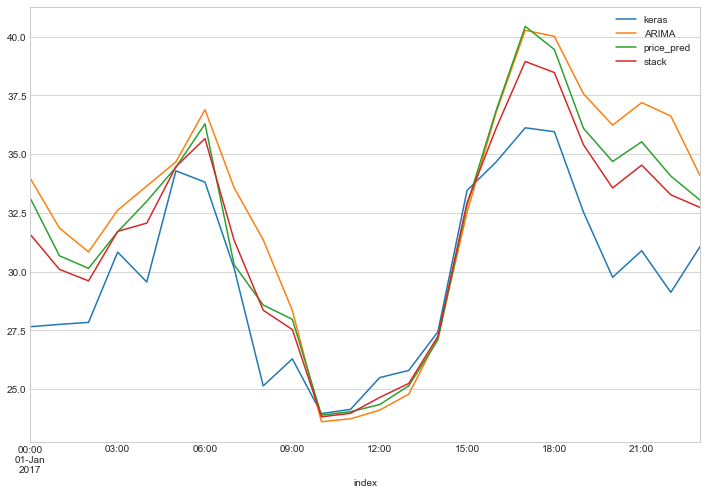

In [260]:
forecast[['keras','ARIMA','price_pred', 'stack']].plot(figsize=(12,8))

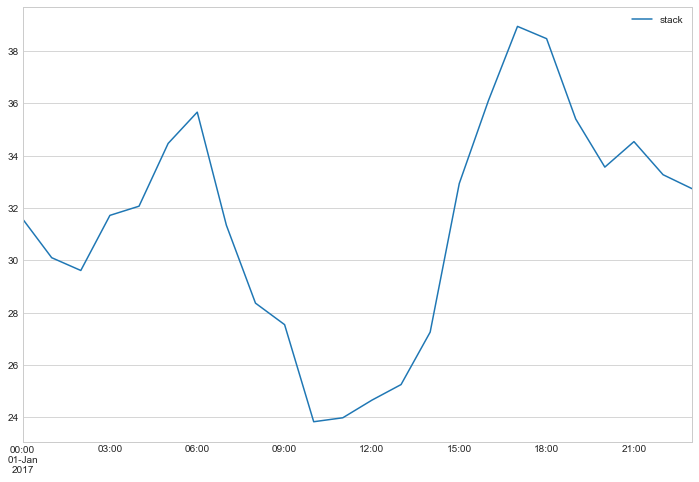

In [261]:
forecast['baseline'] = by_hour['price'].values
future_df = pd.concat([results,forecast])
last = future_df[len(future_df) -24:]
first = future_df[8726:-forecast_period]
last[['stack']].plot(figsize=(12,8))

An important note about the day in question that is being predicted. January 1st in California is New Year's Day which is a national holiday that has some irregularities. First, most Californians are not required to work, so presumably more Californians will stay home and use electricity. Secondly, most Californians will celebrate New Year's Eve which means that electricity demand will be higher in the early, early morning. Given more years of price data we may be able to capture a more general trend for holidays like New Year's Day. However, the ARIMA model will recognize the trend leading up to New Year's day and may indicate certain price patterns that were observable up to that day. Therefore, we expect that the trained model will more accurately reflect the price than the baseline prediction model, as shown below.

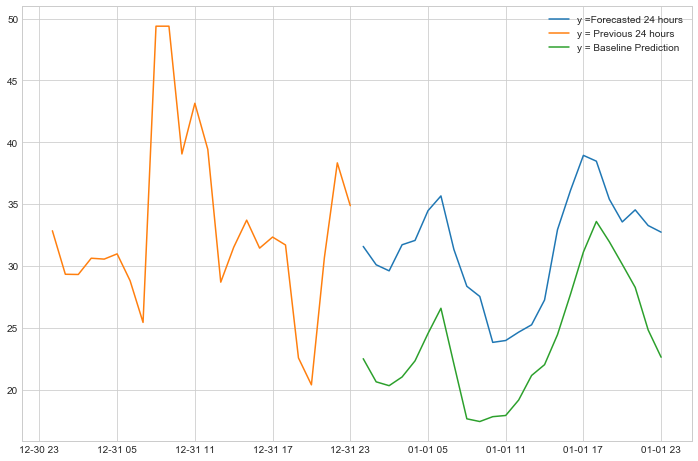

In [262]:
plt.plot(last['stack'])
plt.plot(first['price'])
plt.plot(last['baseline'])

plt.legend(['y =Forecasted 24 hours', 'y = Previous 24 hours', 'y = Baseline Prediction'], loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12,8)

plt.show()

In [263]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [264]:
compare = pd.DataFrame([(first['price'].values),last['stack'].values]).transpose()
compare.columns = [['12/31', '1/1']]

In [265]:
compare

,12/31,1/1
0,32.850033,31.583441
1,29.332359,30.098663
2,29.314642,29.609850
3,30.629392,31.717318
4,30.557637,32.068164
5,30.981096,34.468995
6,28.809665,35.665879
7,25.438228,31.341367
8,49.391338,28.360670
9,49.391338,27.538463
